# Problem Statement:
In today’s world, data is power. With News companies having terabytes of data stored in
servers, everyone is in the quest to discover insights that add value to the organization.
With various examples to quote in which analytics is being used to drive actions, one that
stands out is news article classification.
Nowadays on the Internet there are a lot of sources that generate immense amounts of
daily news. In addition, the demand for information by users has been growing
continuously, so it is crucial that the news is classified to allow users to access the
information of interest quickly and effectively. This way, the machine learning model for
automated news classification could be used to identify topics of untracked news and/or
make individual suggestions based on the user’s prior interests.

## EDA

In [21]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import string
import warnings
warnings.filterwarnings('ignore')
import nltk
from nltk.corpus import stopwords
import gensim
import wordcloud
import textblob
import spacy
import textstat
import pyLDAvis

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to /config/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /config/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /config/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [22]:
df = pd.read_csv("/config/workspace/source/train/train.csv")
df.columns = [column.lower() for column in df.columns]
df.head()

,articleid,text,category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   articleid  1490 non-null   int64 
 1   text       1490 non-null   object
 2   category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


In [24]:
def null_count(df):
    return df.isna().sum()

null_count(df)

articleid    0
text         0
category     0
dtype: int64

### Count the Stop Words

In [25]:
df['stopwords'] = df['text'].apply(lambda x: len([x for x in x.split() if x in stop]))
df[['text', 'stopwords']]


,text,stopwords
0,worldcom ex-boss launches defence lawyers defe...,108
1,german business confidence slides german busin...,120
2,bbc poll indicates economic gloom citizens in ...,220
3,lifestyle governs mobile choice faster bett...,276
4,enron bosses in $168m payout eighteen former e...,142
...,...,...
1485,double eviction from big brother model caprice...,97
1486,dj double act revamp chart show dj duo jk and ...,237
1487,weak dollar hits reuters revenues at media gro...,87
1488,apple ipod family expands market apple has exp...,230


### Number of Punctuations

In [26]:
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return count

df['punctuations'] = df['text'].apply(lambda x: count_punct(x))

In [27]:
df[['text','punctuations']]

,text,punctuations
0,worldcom ex-boss launches defence lawyers defe...,22
1,german business confidence slides german busin...,25
2,bbc poll indicates economic gloom citizens in ...,36
3,lifestyle governs mobile choice faster bett...,42
4,enron bosses in $168m payout eighteen former e...,31
...,...,...
1485,double eviction from big brother model caprice...,22
1486,dj double act revamp chart show dj duo jk and ...,35
1487,weak dollar hits reuters revenues at media gro...,24
1488,apple ipod family expands market apple has exp...,33


### Number of Numerics

In [29]:
df['numerics'] = df['text'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
df[['text','numerics']]

,text,numerics
0,worldcom ex-boss launches defence lawyers defe...,4
1,german business confidence slides german busin...,2
2,bbc poll indicates economic gloom citizens in ...,17
3,lifestyle governs mobile choice faster bett...,4
4,enron bosses in $168m payout eighteen former e...,3
...,...,...
1485,double eviction from big brother model caprice...,2
1486,dj double act revamp chart show dj duo jk and ...,7
1487,weak dollar hits reuters revenues at media gro...,7
1488,apple ipod family expands market apple has exp...,9


### Number of Upper Case Words

In [30]:
df['upper'] = df['text'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
df[['text', 'upper']]

,text,upper
0,worldcom ex-boss launches defence lawyers defe...,0
1,german business confidence slides german busin...,0
2,bbc poll indicates economic gloom citizens in ...,0
3,lifestyle governs mobile choice faster bett...,0
4,enron bosses in $168m payout eighteen former e...,0
...,...,...
1485,double eviction from big brother model caprice...,0
1486,dj double act revamp chart show dj duo jk and ...,0
1487,weak dollar hits reuters revenues at media gro...,0
1488,apple ipod family expands market apple has exp...,0


## Data Cleaning

### Text to Lower Case

In [31]:
df['text'] = df['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['text'].head()

0    worldcom ex-boss launches defence lawyers defe...
1    german business confidence slides german busin...
2    bbc poll indicates economic gloom citizens in ...
3    lifestyle governs mobile choice faster better ...
4    enron bosses in $168m payout eighteen former e...
Name: text, dtype: object

### Removing Punctuations

In [32]:
df['text'] = df['text'].str.replace("[^\w\s]","")
df['text'].head()

0    worldcom exboss launches defence lawyers defen...
1    german business confidence slides german busin...
2    bbc poll indicates economic gloom citizens in ...
3    lifestyle governs mobile choice faster better ...
4    enron bosses in 168m payout eighteen former en...
Name: text, dtype: object

### Removing Stop Words

In [33]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['text'].head()

0    worldcom exboss launches defence lawyers defen...
1    german business confidence slides german busin...
2    bbc poll indicates economic gloom citizens maj...
3    lifestyle governs mobile choice faster better ...
4    enron bosses 168m payout eighteen former enron...
Name: text, dtype: object

### Remove URLs

In [37]:
def remove_url(text):
    return re.sub(r'\S*https?:\S*','', text)

In [38]:
df['text'] = df['text'].apply(lambda x: remove_url(x))
df['text'].head()

0    worldcom exboss launches defence lawyers defen...
1    german business confidence slides german busin...
2    bbc poll indicates economic gloom citizens maj...
3    lifestyle governs mobile choice faster better ...
4    enron bosses 168m payout eighteen former enron...
Name: text, dtype: object

### Remove HTML Tags

In [40]:
def remove_html(text):
    return re.sub(r"<.*?>","", text)

In [41]:
df['text'] = df['text'].apply(lambda x: remove_html(x))
df['text']

0       worldcom exboss launches defence lawyers defen...
1       german business confidence slides german busin...
2       bbc poll indicates economic gloom citizens maj...
3       lifestyle governs mobile choice faster better ...
4       enron bosses 168m payout eighteen former enron...
                              ...                        
1485    double eviction big brother model caprice holb...
1486    dj double act revamp chart show dj duo jk joel...
1487    weak dollar hits reuters revenues media group ...
1488    apple ipod family expands market apple expande...
1489    santy worm makes unwelcome visit thousands web...
Name: text, Length: 1490, dtype: object

### Remove Emoji's

In [44]:
def remove_emoji(text):
    return re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE).sub(r'', text)

In [45]:
df['text'] = df['text'].apply(lambda x: remove_emoji(x))
df['text'].head()

0    worldcom exboss launches defence lawyers defen...
1    german business confidence slides german busin...
2    bbc poll indicates economic gloom citizens maj...
3    lifestyle governs mobile choice faster better ...
4    enron bosses 168m payout eighteen former enron...
Name: text, dtype: object

### Spell Correction

In [46]:
from textblob import TextBlob
df['text'][:5].apply(lambda x: str(TextBlob(x).correct()))

0    worldcom excess launched defence lawyers defen...
1    german business confidence sides german busine...
2    bc poll indicates economic gloom citizens majo...
3    lifestyle governs mobile choice faster better ...
4    union bosses 168m layout eighteen former union...
Name: text, dtype: object

In [39]:
df['text'][df['text'].duplicated()==True].count()

52

<AxesSubplot: >

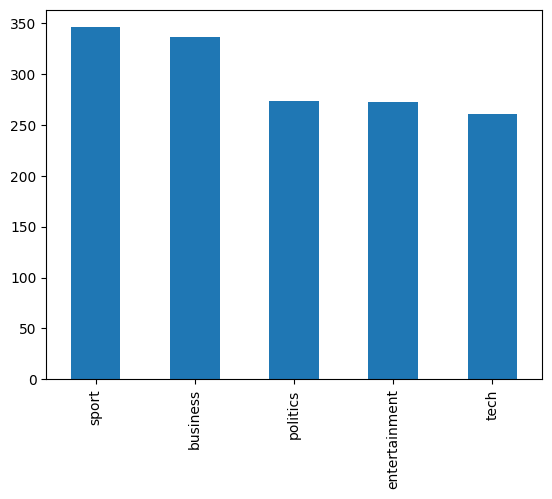

In [ ]:
df['Category'].value_counts().plot(kind='bar')

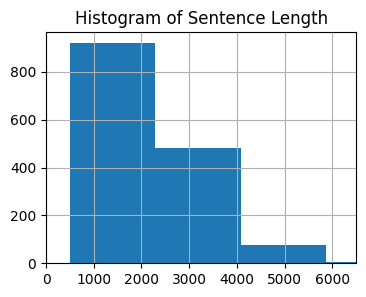

In [ ]:
plt.figure(figsize=(4,3))
df['Text'].str.len().hist()
plt.xlim([0,6500])
plt.title("Histogram of Sentence Length")
plt.show()

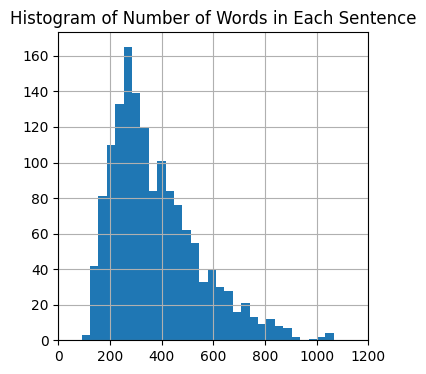

In [ ]:
plt.figure(figsize=(4,4))
plt.title("Histogram of Number of Words in Each Sentence")
df['Text'].str.split().map(lambda x: len(x)).hist(bins=100)
plt.xlim([0,1200])
plt.show()

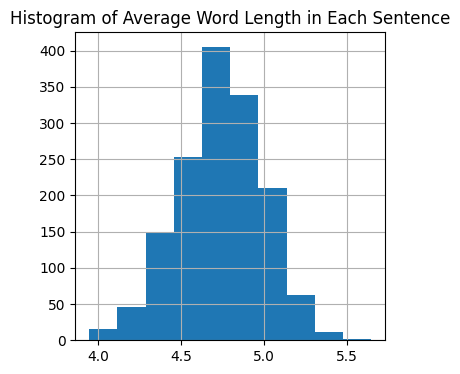

In [ ]:
plt.figure(figsize=(4,4))
df['Text'].str.split().apply(lambda x: [len(i) for i in x]).map(lambda x: np.mean(x)).hist()
plt.title("Histogram of Average Word Length in Each Sentence")
plt.show()

From the Above figure we can conclude below
* Each Sentence length in a news article is ranging from 500 to 6000
* The number of words in each sentence is ranging from 100 to 1100
* Average Word length in each sentence is ranging from 3.5 to 5.5

In [ ]:
sample = df['Text'].sample(1).values[0]
sample

'prince crowned  top music earner  prince earned more than any other pop star in 2004  beating artists such madonna and elton john in us magazine rolling stone s annual list.  the singer banked $56.5m (£30.4m) from concerts  album and publishing sales with his musicology tour and album. he kept madonna in second place  as she earned $54.9m (£29.5m) while embarking on her global re-invention tour. veterans simon and garfunkel were in 10th place  their comeback tour helping them earn $24.9m (£13.4m) last year.   prince returned to centre stage after a decade in the commercial wilderness   the magazine reported. the singer s 2004 tour took $90.3m (£48.5m) in ticket sales and he sold 1.9 million copies of his latest album musicology.  although she grossed more than prince last year  madonna remained in second place because of the  monumental  production costs of her tour. heavy metal band metallica s madly in anger with the world tour helped push their 2004 earnings up to $43.1m (£23.1m). 

In [ ]:
sample = " ".join([x.lower() for x in sample.split()])
sample

'prince crowned top music earner prince earned more than any other pop star in 2004 beating artists such madonna and elton john in us magazine rolling stone s annual list. the singer banked $56.5m (£30.4m) from concerts album and publishing sales with his musicology tour and album. he kept madonna in second place as she earned $54.9m (£29.5m) while embarking on her global re-invention tour. veterans simon and garfunkel were in 10th place their comeback tour helping them earn $24.9m (£13.4m) last year. prince returned to centre stage after a decade in the commercial wilderness the magazine reported. the singer s 2004 tour took $90.3m (£48.5m) in ticket sales and he sold 1.9 million copies of his latest album musicology. although she grossed more than prince last year madonna remained in second place because of the monumental production costs of her tour. heavy metal band metallica s madly in anger with the world tour helped push their 2004 earnings up to $43.1m (£23.1m). they were ahead

In [ ]:
sample

['chinese',
 'exports',
 'rise',
 '25%',
 'in',
 '2004',
 'exports',
 'from',
 'china',
 'leapt',
 'during',
 '2004',
 'over',
 'the',
 'previous',
 'year',
 'as',
 'the',
 'country',
 'continued',
 'to',
 'show',
 'breakneck',
 'growth.',
 'the',
 'spurt',
 'put',
 'china',
 's',
 'trade',
 'surplus',
 '-',
 'a',
 'sore',
 'point',
 'with',
 'some',
 'of',
 'its',
 'trading',
 'partners',
 '-',
 'at',
 'a',
 'six-year',
 'high.',
 'it',
 'may',
 'also',
 'increase',
 'pressure',
 'on',
 'china',
 'to',
 'relax',
 'the',
 'peg',
 'joining',
 'its',
 'currency',
 'the',
 'yuan',
 'with',
 'the',
 'weakening',
 'dollar.',
 'the',
 'figures',
 'released',
 'by',
 'the',
 'ministry',
 'of',
 'commerce',
 'come',
 'as',
 'china',
 's',
 'tax',
 'chief',
 'confirmed',
 'that',
 'growth',
 'had',
 'topped',
 '9%',
 'in',
 '2004',
 'for',
 'the',
 'second',
 'year',
 'in',
 'a',
 'row.',
 'state',
 'administration',
 'of',
 'taxation',
 'head',
 'xie',
 'xuren',
 'said',
 'a',
 'tightening',
 